### 앙상블 학습

In [2]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data=pd.DataFrame(cancer.data,columns=cancer.feature_names)
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
lr_clf=LogisticRegression()
knn_clf=KNeighborsClassifier(n_neighbors=8)

vo_clf=VotingClassifier(estimators=[('LR',lr_clf),('KNN',knn_clf)],voting='soft')

X_train,X_test,y_train,y_test=train_test_split(cancer.data,cancer.target,test_size=0.2,random_state=156)

In [11]:
vo_clf.fit(X_train,y_train)
pred=vo_clf.predict(X_test)
print(f'보팅 분류기 정확도 : {accuracy_score(y_test,pred)}')

보팅 분류기 정확도 : 0.9473684210526315


C:\Users\gommg\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [12]:
# 개별 모델 학습.평가
classifiers=[lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train,y_train)
    pred=classifier.predict(X_test)
    class_name=classifier.__class__.__name__
    print(f'{class_name} 정확도 : {accuracy_score(y_test,pred)}')

LogisticRegression 정확도 : 0.9385964912280702
KNeighborsClassifier 정확도 : 0.9385964912280702


C:\Users\gommg\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 랜덤 포레스트

In [17]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_datasets():
    feature_name_df=pd.read_csv('./human_activity/features.txt',sep='\s+',
                      header=None, names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_datasets()

In [40]:
rf_clf=RandomForestClassifier(random_state=0)
rf_clf.fit(X_train,y_train)
pred=rf_clf.predict(X_test)
accuracy=accuracy_score(y_test,pred)
print(f'랜덤포레스트 정확도: {round(accuracy,4)}')

랜덤포레스트 정확도: 0.9253


In [24]:
from sklearn.model_selection import GridSearchCV

params={
    'n_estimators':[100],
    'max_depth':[6,8,10,12],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20]
}

rf_clf=RandomForestClassifier(random_state=0,n_jobs=1)
grid_cv=GridSearchCV(rf_clf,param_grid=params,cv=2,n_jobs=1)
grid_cv.fit(X_train,y_train)

print(f'최적 하이퍼 파라미터: \n {grid_cv.best_params_}')
print(f'최고 정확도: {round(grid_cv.best_score_,4)}')

최적 하이퍼 파라미터: 
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 정확도: 0.918


In [25]:
rf_clf1=RandomForestClassifier(random_state=0,n_estimators=100,max_depth=10,min_samples_leaf=8,
                              min_samples_split=8)
rf_clf1.fit(X_train,y_train)
pred=rf_clf1.predict(X_test)
print(f'정확도: {round(accuracy_score(y_test,pred),4)}')

정확도: 0.9196


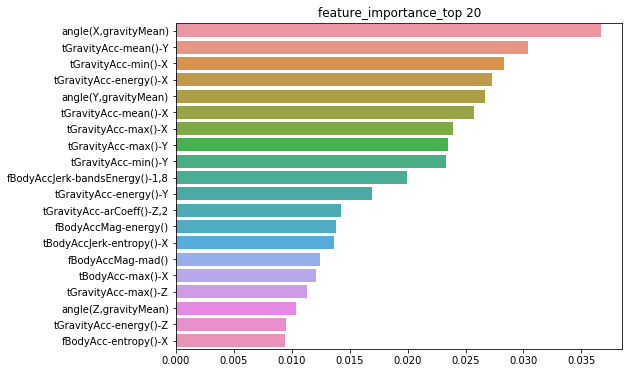

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values=rf_clf1.feature_importances_
ftr_importances=pd.Series(ftr_importances_values,index=X_train.columns)
ftr_top20=ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('feature_importance_top 20')
sns.barplot(x=ftr_top20,y=ftr_top20.index);

### GBM(Gradient Bossting Machine)

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
import time

X_train,X_test,y_train,y_test=get_human_datasets()
start_time=time.time()

gb_clf=GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train,y_train)
gb_pred =gb_clf.predict(X_test)
gb_accuracy=accuracy_score(y_test,gb_pred)

print(f'GBM 정확도: {round(gb_accuracy,4)}')
print(f'GBM 수행 시간: {time.time()-start_time}초')

GBM 정확도: 0.9382


TypeError: 'float' object is not callable

In [34]:
print(f'GBM 수행 시간: {time.time()-start_time}초')

GBM 수행 시간: 716.1457467079163초


In [36]:
from sklearn.model_selection import GridSearchCV
start_time=time.time()

params={
    'n_estimators':[100,500],
    'learning_rate':[0.05,0.1]
}

gird_cv=GridSearchCV(gb_clf,param_grid=params,cv=2,verbose=1)
gird_cv.fit(X_train,y_train)
print(f'최적 파라미터: {grid_cv.best_params_}')
print(f'최고 정확도: {round(gird_cv.best_score_,4)}')
print(f'grid_cv 수행 시간: {time.time()-start_time}초')

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 63.7min finished


최적 파라미터: {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 정확도: 0.9013
grid_cv 수행 시간: 5919.486418008804초


In [39]:
gb_pred=grid_cv.best_estimator_.predict(X_test)
gb_accuracy=accuracy_score(y_test,gb_pred)
print(f'GBM 정확도: {round(gb_accuracy,4)}')

GBM 정확도: 0.9196


### XGBboost

In [41]:
import xgboost as xgb
from xgboost import XGBClassifier

In [46]:
import xgboost
print(xgboost.__version__)

0.90


In [48]:
import pandas as pd
from xgboost import plot_importance
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split


In [49]:
data=load_breast_cancer()
X_features=data.data
y_label=data.target

In [52]:
cancer_df=pd.DataFrame(data=X_features,columns=data.feature_names)
cancer_df['target']=y_label
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [54]:
cancer_df['target'].value_counts()

1    357
0    212
Name: target, dtype: int64

In [55]:
X_train,X_test,y_train,y_test=train_test_split(X_features,y_label,test_size=0.2, random_state=0)

In [56]:
X_train.shape

(455, 30)

In [57]:
dtrain=xgb.DMatrix(X_train,y_train)

In [58]:
dtest=xgb.DMatrix(X_test,y_test)

In [60]:
params={'max_depth':3,
        'eta':0.1,
        'eval_metric':'logloss',
        'early_stoppings':100
}
num_rounds=400

In [63]:
wlist=[(dtrain,'train'),(dtest,'eval')]
xgb_model=xgb.train(params=params,dtrain=dtrain,num_boost_round=num_rounds,
                   early_stopping_rounds=100,evals=wlist)

[0]	train-logloss:0.60823	eval-logloss:0.61061
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.537895	eval-logloss:0.541056
[2]	train-logloss:0.478641	eval-logloss:0.48391
[3]	train-logloss:0.426689	eval-logloss:0.434944
[4]	train-logloss:0.38232	eval-logloss:0.394038
[5]	train-logloss:0.342823	eval-logloss:0.357278
[6]	train-logloss:0.31107	eval-logloss:0.326725
[7]	train-logloss:0.280098	eval-logloss:0.298159
[8]	train-logloss:0.253053	eval-logloss:0.275193
[9]	train-logloss:0.229354	eval-logloss:0.253689
[10]	train-logloss:0.209072	eval-logloss:0.234757
[11]	train-logloss:0.192363	eval-logloss:0.218959
[12]	train-logloss:0.176037	eval-logloss:0.203539
[13]	train-logloss:0.161414	eval-logloss:0.187443
[14]	train-logloss:0.148612	eval-logloss:0.175718
[15]	train-logloss:0.136482	eval-logloss:0.163267
[16]	train-logloss:0.126079	eval-logloss:0.153411
[17]	train-logl

[161]	train-logloss:0.010759	eval-logloss:0.072824
[162]	train-logloss:0.010736	eval-logloss:0.072813
[163]	train-logloss:0.010615	eval-logloss:0.072856
[164]	train-logloss:0.010487	eval-logloss:0.072629
[165]	train-logloss:0.010404	eval-logloss:0.07258
[166]	train-logloss:0.010325	eval-logloss:0.072647
[167]	train-logloss:0.010293	eval-logloss:0.072683
[168]	train-logloss:0.010211	eval-logloss:0.072688
[169]	train-logloss:0.01016	eval-logloss:0.072708
[170]	train-logloss:0.009934	eval-logloss:0.072507
[171]	train-logloss:0.009923	eval-logloss:0.072575
[172]	train-logloss:0.009858	eval-logloss:0.072514
[173]	train-logloss:0.009795	eval-logloss:0.072536
[174]	train-logloss:0.009716	eval-logloss:0.072482
[175]	train-logloss:0.009617	eval-logloss:0.072235
[176]	train-logloss:0.009561	eval-logloss:0.072263
[177]	train-logloss:0.009526	eval-logloss:0.072214
[178]	train-logloss:0.009483	eval-logloss:0.072264
[179]	train-logloss:0.009404	eval-logloss:0.072283
[180]	train-logloss:0.009332	eval

In [66]:
pred_probs=xgb_model.predict(dtest)
print(f'10개만 표시, 예측 확률값이다')
print(np.round(pred_probs[:10],3))

# 예측 확률 0.5 이상이면 1, 아니면 0으로 표시
preds=[1 if x>0.5 else 0 for x in pred_probs]
print(f'10개만 표시 {preds[:10]}')

10개만 표시, 예측 확률값이다
[-0.02   0.972  0.994  0.971  0.99   0.907  1.111  1.006  1.023  1.027]
10개만 표시 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [79]:
def get_clf_eval(y_test,pred):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    confusion=confusion_matrix(y_test,pred)
    accuracy=round(accuracy_score(y_test,pred),4)
    precision=round(precision_score(y_test,pred),4)
    recall=round(recall_score(y_test,pred),4)
    f1=round(f1_score(y_test,pred),4)
    roc_score=round(roc_auc_score(y_test,pred),4)
    
    print('오차행렬')
    print(confusion,'\n')
    print(f'정확도 :{accuracy}, 정밀도: {precision}, 재현율: {recall}, F1 스코어: {f1}, ROC AUC: {roc_score}\n')
    

In [80]:
get_clf_eval(y_test,preds)

오차행렬
[[45  2]
 [ 2 65]] 

정확도 :0.9649, 정밀도: 0.9701, 재현율: 0.9701, F1 스코어: 0.9701, ROC AUC: 0.9638



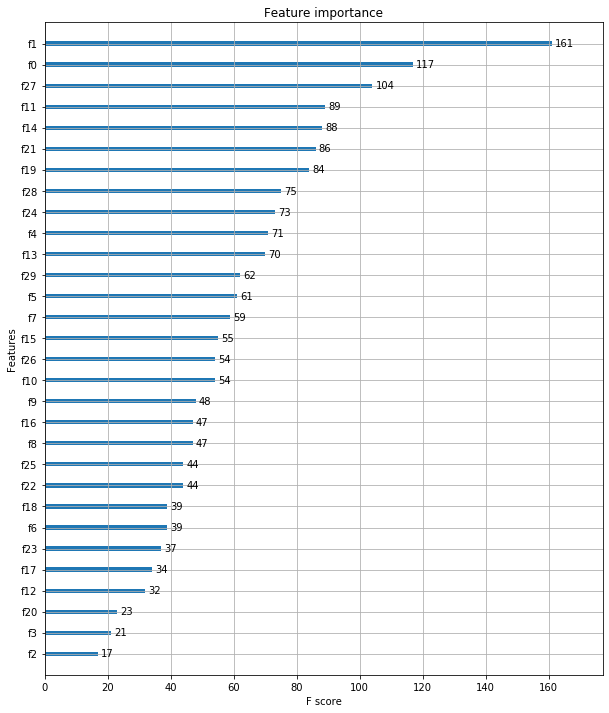

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline

f,ax=plt.subplots(figsize=(10,12))
plot_importance(xgb_model,ax=ax);

In [83]:
from xgboost import XGBClassifier
xgb_wrapper=XGBClassifier(n_estimators=400,learning_rate=0.1,max_depth=3)
xgb_wrapper.fit(X_train,y_train)
w_preds=xgb_wrapper.predict(X_test)
w_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

In [88]:
get_clf_eval(y_test,w_preds)

오차행렬
[[46  1]
 [ 0 67]] 

정확도 :0.9912, 정밀도: 0.9853, 재현율: 1.0, F1 스코어: 0.9926, ROC AUC: 0.9894



In [93]:
xgb_wrapper=XGBClassifier(n_estimators=400,learning_rate=0.1,max_depth=3)
evals=[(X_test,y_test)]
xgb_wrapper.fit(X_train,y_train,early_stopping_rounds=100,eval_metric='logloss',
               eval_set=evals,verbose=True)
ws100_preds=xgb_wrapper.predict(X_test)
ws100_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.613695
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.545425
[2]	validation_0-logloss:0.489016
[3]	validation_0-logloss:0.440352
[4]	validation_0-logloss:0.399575
[5]	validation_0-logloss:0.364348
[6]	validation_0-logloss:0.332736
[7]	validation_0-logloss:0.306005
[8]	validation_0-logloss:0.282808
[9]	validation_0-logloss:0.261858
[10]	validation_0-logloss:0.243811
[11]	validation_0-logloss:0.227002
[12]	validation_0-logloss:0.213091
[13]	validation_0-logloss:0.200189
[14]	validation_0-logloss:0.186999
[15]	validation_0-logloss:0.176615
[16]	validation_0-logloss:0.167341
[17]	validation_0-logloss:0.157389
[18]	validation_0-logloss:0.150211
[19]	validation_0-logloss:0.142762
[20]	validation_0-logloss:0.136049
[21]	validation_0-logloss:0.13016
[22]	validation_0-logloss:0.123783
[23]	validation_0-logloss:0.118088
[24]	validation_0-logloss:0.114797
[25]	validation_0-logloss:0.111367
[26]	validation_0-logloss:0.1070

[230]	validation_0-logloss:0.048158
[231]	validation_0-logloss:0.048198
[232]	validation_0-logloss:0.04817
[233]	validation_0-logloss:0.048199
[234]	validation_0-logloss:0.04801
[235]	validation_0-logloss:0.048059
[236]	validation_0-logloss:0.047842
[237]	validation_0-logloss:0.047895
[238]	validation_0-logloss:0.047812
[239]	validation_0-logloss:0.047909
[240]	validation_0-logloss:0.0477
[241]	validation_0-logloss:0.047729
[242]	validation_0-logloss:0.047796
[243]	validation_0-logloss:0.047688
[244]	validation_0-logloss:0.047562
[245]	validation_0-logloss:0.047513
[246]	validation_0-logloss:0.047562
[247]	validation_0-logloss:0.047358
[248]	validation_0-logloss:0.047388
[249]	validation_0-logloss:0.047451
[250]	validation_0-logloss:0.047492
[251]	validation_0-logloss:0.047545
[252]	validation_0-logloss:0.047362
[253]	validation_0-logloss:0.047257
[254]	validation_0-logloss:0.047301
[255]	validation_0-logloss:0.047102
[256]	validation_0-logloss:0.047155
[257]	validation_0-logloss:0.047

In [94]:
get_clf_eval(y_test,ws100_preds)

오차행렬
[[46  1]
 [ 0 67]] 

정확도 :0.9912, 정밀도: 0.9853, 재현율: 1.0, F1 스코어: 0.9926, ROC AUC: 0.9894



In [95]:
xgb_wrapper=XGBClassifier(n_estimators=400,learning_rate=0.1,max_depth=3)
evals=[(X_test,y_test)]
xgb_wrapper.fit(X_train,y_train,early_stopping_rounds=10,eval_metric='logloss',
               eval_set=evals,verbose=True)
ws100_preds=xgb_wrapper.predict(X_test)
ws100_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.613695
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.545425
[2]	validation_0-logloss:0.489016
[3]	validation_0-logloss:0.440352
[4]	validation_0-logloss:0.399575
[5]	validation_0-logloss:0.364348
[6]	validation_0-logloss:0.332736
[7]	validation_0-logloss:0.306005
[8]	validation_0-logloss:0.282808
[9]	validation_0-logloss:0.261858
[10]	validation_0-logloss:0.243811
[11]	validation_0-logloss:0.227002
[12]	validation_0-logloss:0.213091
[13]	validation_0-logloss:0.200189
[14]	validation_0-logloss:0.186999
[15]	validation_0-logloss:0.176615
[16]	validation_0-logloss:0.167341
[17]	validation_0-logloss:0.157389
[18]	validation_0-logloss:0.150211
[19]	validation_0-logloss:0.142762
[20]	validation_0-logloss:0.136049
[21]	validation_0-logloss:0.13016
[22]	validation_0-logloss:0.123783
[23]	validation_0-logloss:0.118088
[24]	validation_0-logloss:0.114797
[25]	validation_0-logloss:0.111367
[26]	validation_0-logloss:0.10701

In [96]:
get_clf_eval(y_test,ws100_preds)

오차행렬
[[45  2]
 [ 1 66]] 

정확도 :0.9737, 정밀도: 0.9706, 재현율: 0.9851, F1 스코어: 0.9778, ROC AUC: 0.9713



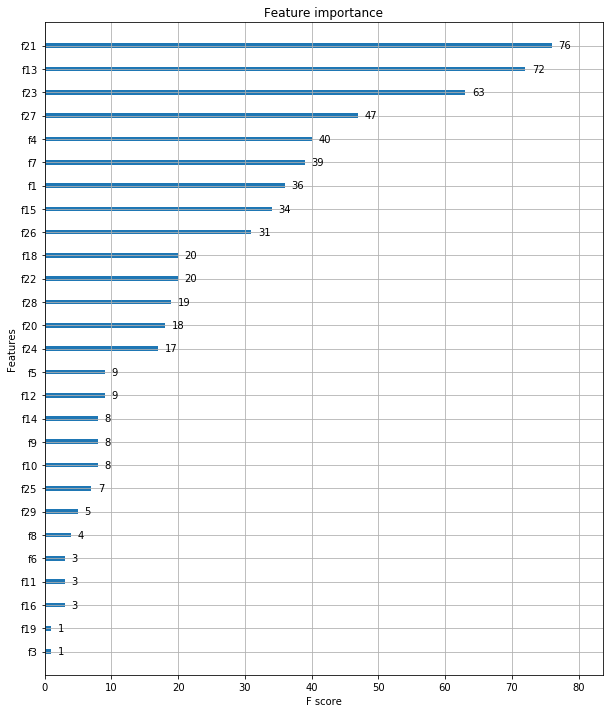

In [100]:
f,ax=plt.subplots(figsize=(10,12))
plot_importance(xgb_wrapper,ax=ax);